In [1]:
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchvision.models import resnet18
from torchcam.methods import SmoothGradCAMpp,GradCAM, XGradCAM, GradCAMpp,LayerCAM, CAM, ScoreCAM, SSCAM, ISCAM
import torch.nn as nn

In [62]:
 

import torch.nn as nn
import torchvision.models


def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )


class ResNetUNet(nn.Module):
    
    
    def __init__(self, n_class):
        
        super().__init__()

        self.base_model = torchvision.models.resnet18(pretrained=True)
        self.base_layers = list(self.base_model.children())

        self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)
        self.layer1_1x1 = convrelu(64, 64, 1, 0)
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
        self.layer2_1x1 = convrelu(128, 128, 1, 0)
        self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
        self.layer3_1x1 = convrelu(256, 256, 1, 0)
        self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        self.layer4_1x1 = convrelu(512, 512, 1, 0)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

        self.conv_last = nn.Conv2d(64, n_class, 1)

    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)

        layer0 = self.layer0(input)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)

        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        # import pdb; pdb.set_trace()
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)

        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)

        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)

        out = self.conv_last(x)

        return out

In [2]:
import torch
import cv2
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from PIL import Image

def my_read_image(path):
    
    img = cv2.imread(path)
    # Convert BGR image to RGB image
    # image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # image = img
    image = Image.fromarray(img)
    
    resize = transforms.Resize(size=(556,556))
    image = resize(image)
    image = TF.center_crop(image,512)

    # Define a transform to convert
    # the image to torch tensor
    transform = transforms.Compose([
        transforms.ToTensor()
    ])

    # Convert the image to Torch tensor
    tensor = transform(image)
    return tensor

In [3]:
import torch
from PIL import Image
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

def my_read_image_pil(path):
   # Read a PIL image
    image = Image.open(path).convert('RGB')
    
    resize = transforms.Resize(size=(556,556))
    image = resize(image)
    image = TF.center_crop(image,512)

    # Define a transform to convert PIL 
    # image to a Torch tensor
    transform = transforms.Compose([
        transforms.PILToTensor()
    ])
    
    # Convert the image to Torch tensor
    tensor = transform(image)
    return tensor

In [32]:
temp =my_read_image_pil(path_img)

In [23]:
temp.shape

torch.Size([3, 5431, 3136])

In [48]:
temp2 =my_read_image(path_img)

In [4]:
#model_path = "/home/noisy/codes/WSOD/mamo_wsms/notebooks/output/segmentation/bs8_size512_ep5_lr0.0001_bcew0.0/trained_model_seg.pth"
model_path = "/home/noisy/codes/WSOD/mamo_wsms/notebooks/output/classification/bs16_size512_ep5_lr1e-05/trained_model_classif.pth"


In [67]:
#load model
model = ResNetUNet(1).cuda()
num_class)
model = model.to(device)
model.eval()

ResNetUNet(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [10]:
#load model 
model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model.load_state_dict(torch.load(model_path))
# model.eval()

<All keys matched successfully>

In [17]:


# model = resnet18(pretrained=True).eval()
# cam_extractor = SmoothGradCAMpp(model, 'layer4')
cam_extractor = GradCAM(model, 'layer4')
# cam_extractor = XGradCAM(model, 'layer4')
# cam_extractor = GradCAMpp(model, 'layer4')
# cam_extractor = LayerCAM(model, 'layer4')
# cam_extractor = CAM(model, 'layer4')
# cam_extractor = ScoreCAM(model, 'layer4')
# cam_extractor = SSCAM(model, 'layer4')
# cam_extractor = ISCAM(model, 'layer4')






# Get your input
#img = read_image("path/to/your/image.png")
# path_img = "/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/full/Mass-Test_P_00017_LEFT_CC_FULL.png"
path_img = "/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/full/Mass-Test_P_00131_LEFT_CC_FULL.png"
# path_img = "/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/full/Mass-Test_P_00116_RIGHT_MLO_FULL.png"



# path_img = "/home/noisy/codes/WSOD/mamo_wsms/notebooks/output/classification/bs16_size512_ep5_lr1e-05/trained_model_classif.pth"
#img = my_read_image_pil(path_img)
img = my_read_image(path_img)
# img = read_image("/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/full/Mass-Test_P_00017_LEFT_CC_FULL.png")
# Preprocess it for your chosen model
#input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
input_tensor = TF.normalize(img, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# input_tensor = normalize(resize(img, (512, 512)) / 255., [0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
# input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

# Preprocess your data and feed it to the model
out = model(input_tensor.unsqueeze(0))
# Retrieve the CAM by passing the class index and the model output
activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)

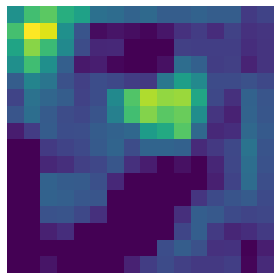

In [18]:
import matplotlib.pyplot as plt
# Visualize the raw CAM
plt.imshow(activation_map[0].squeeze(0).numpy()); plt.axis('off'); plt.tight_layout(); plt.show()

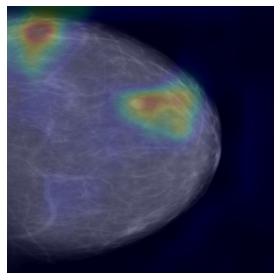

In [19]:
import matplotlib.pyplot as plt
from torchcam.utils import overlay_mask

# Resize the CAM and overlay it
result = overlay_mask(to_pil_image(img), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.8)
# Display it
plt.imshow(result); plt.axis('off'); plt.tight_layout(); plt.show()

In [129]:
cam_extractor.clear_hooks()

AttributeError: 'GradCAMpp' object has no attribute 'clear_hooks'

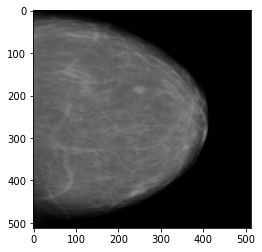

In [66]:
plt.imshow(to_pil_image(img))